# Random Forest Model

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

## Load Data

In [3]:
def load_data_and_filter_ids(file_path):
    """
    Loads data from a CSV file, checks for NaN values in 'step' column grouped by 'series_id',
    and returns a list of 'series_id' values that do not contain NaNs.
    
    :param file_path: Path to the CSV file.
    :return: List of series IDs without NaN values in the 'step' column.
    """
    # Load data from CSV
    train_events = pd.read_csv(file_path)

    # Group by 'series_id' and check for NaN values in 'step' column
    series_has_nan = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())

    # Get list of series IDs that do not contain NaN values
    train_ids = series_has_nan[~series_has_nan].index.tolist()

    return train_ids

# Usage example:
file_path = "../data/train_events.csv"
train_ids = load_data_and_filter_ids(file_path)

## Feature Engineering

In [4]:
def get_multi_light_series(series_ids):
    """
    Fetches and processes a dataset for the given series IDs.

    :param series_ids: List of series IDs to fetch.
    :return: Processed DataFrame with added features.
    """
    print(f'Fetching series IDs: {series_ids} \n')
    file_path = "../data/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet"
    multi_series = pd.read_parquet(file_path, filters=[('series_id', 'in', series_ids)])
    multi_series = multi_series.astype({'series_id': 'category', 'step': 'int16', 'awake': 'int16'})
    multi_series = add_features(multi_series)
    print("Columns in multi_series:", multi_series.columns)

    return multi_series

def add_features(df):
    """
    Adds various features to the DataFrame.

    :param df: DataFrame to which features are added.
    :return: DataFrame with added features.
    """
    df = add_time_features(df)
    df = add_interaction_features(df)
    df = add_rolling_features(df, periods=6)  # 1/2 minute
    df = pd.get_dummies(df, columns=['series_id'], drop_first=True)
    df = df.drop('timestamp', axis =1)

    return df

def add_time_features(df):
    """ Adds time-related features to the DataFrame. """
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    return df

def add_interaction_features(df):
    """ Adds interaction features to the DataFrame. """
    df["anglez_times_enmo"] = abs(df["anglez"]) * df["enmo"]
    return df

def add_rolling_features(df, periods):
    """ Adds rolling features to the DataFrame. """
    # Define operations to be applied
    operations = ["mean", "min", "max", "std"]
    columns = ["anglez", "enmo"]

    for column in columns:
        for operation in operations:
            df[f"{column}_{operation}"] = (
                df[column].rolling(periods, center=True).agg(operation).bfill().ffill().astype('float32')
            )

        # Differential features
        df[f"{column}_diff"] = (
            df.groupby('series_id', observed=True)[column].diff(periods=periods).bfill()
        )
        df[f"{column}_diff_rolling"] = (
            df[f"{column}_diff"].rolling(periods, center=True).mean().bfill().ffill().astype('float32')
        )

    return df

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a confusion matrix.

    :param y_true: True labels.
    :param y_pred: Predicted labels.
    :param classes: List of class labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

In [5]:
%time train_all = get_multi_light_series(train_ids[:8])
print(f'memory usage: {train_all.memory_usage().sum() / 1024**2: .2f} MB')

Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 

Columns in multi_series: Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       'series_id_0a96f4993bd7', 'series_id_0cfc06c129cc',
       'series_id_1087d7b0ff2e', 'series_id_10f8bc1f7b07',
       'series_id_18b61dd5aae8', 'series_id_29c75c018220'],
      dtype='object')
CPU times: user 17.8 s, sys: 1.11 s, total: 18.9 s
Wall time: 17.4 s
memory usage:  211.62 MB


In [6]:
train_all.head()

,step,anglez,enmo,awake,hour,dayofweek,anglez_times_enmo,anglez_mean,anglez_min,anglez_max,...,enmo_max,enmo_std,enmo_diff,enmo_diff_rolling,series_id_0a96f4993bd7,series_id_0cfc06c129cc,series_id_1087d7b0ff2e,series_id_10f8bc1f7b07,series_id_18b61dd5aae8,series_id_29c75c018220
0,0,-30.845301,0.0447,1,14,0,1.378785,-33.749619,-34.925598,-30.845301,...,0.0768,0.013588,0.0626,0.0626,False,False,False,False,False,False
1,1,-34.181801,0.0443,1,14,0,1.514254,-33.749619,-34.925598,-30.845301,...,0.0768,0.013588,0.0626,0.0626,False,False,False,False,False,False
2,2,-33.877102,0.0483,1,14,0,1.636264,-33.749619,-34.925598,-30.845301,...,0.0768,0.013588,0.0626,0.0626,False,False,False,False,False,False
3,3,-34.282101,0.0680,1,14,0,2.331183,-33.749619,-34.925598,-30.845301,...,0.0768,0.013588,0.0626,0.0626,False,False,False,False,False,False
4,4,-34.385799,0.0768,1,14,0,2.640830,-33.694302,-34.925598,-30.513399,...,0.1073,0.023801,0.0626,0.0626,False,False,False,False,False,False


## Data Preprocessing

In [7]:
def scale_features_and_extract_target(df, feature_names, target_name):
    """
    Scales the features of the dataset and extracts the target variable.

    :param df: DataFrame containing the dataset.
    :param feature_names: List of feature names to be scaled.
    :param target_name: Name of the target variable.
    :return: Tuple of scaled features array and target variable array.
    """
    # Initialize the scaler
    scaler = StandardScaler()

    # Scale the features
    df_features_scaled = scaler.fit_transform(df[feature_names])

    # Extract the target variable
    df_target = df[target_name].values

    return df_features_scaled, df_target

# Example usage:
features = ["step", "hour", "dayofweek", "anglez_times_enmo",
            "anglez", "anglez_diff", "anglez_mean", "anglez_min", "anglez_max", "anglez_std", "anglez_diff_rolling",
            "enmo", "enmo_diff", "enmo_mean", "enmo_min", "enmo_max", "enmo_std", "enmo_diff_rolling"]
target = 'awake'

# Assuming 'train_all' is your DataFrame
df_train_X_scaled, df_train_y = scale_features_and_extract_target(train_all, features, target)

## Split Data

In [8]:
def prepare_data_and_split(df_features, df_target, split_ratio=0.8, convert_to_tensor=True):
    """
    Converts feature and target dataframes into PyTorch tensors and splits them into training and validation sets.

    :param df_features: DataFrame or array containing the feature data.
    :param df_target: DataFrame or array containing the target data.
    :param split_ratio: Float representing the proportion of the dataset to include in the train split.
    :param convert_to_tensor: Boolean 
    :return: Tuples of tensors (X_train, y_train), (X_val, y_val).
    """

    if convert_to_tensor:
        X = tensor(df_features, dtype=torch.float32)
        y = tensor(df_target, dtype=torch.long)
    else:
        X, y = df_features, df_target

    # Split the data
    split_index = int(len(X) * split_ratio)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return (X_train, y_train), (X_val, y_val)

In [9]:
(X_train, y_train), (X_val, y_val) = prepare_data_and_split(df_train_X_scaled, df_train_y, convert_to_tensor=False)

# Checking the shapes
print("Train shapes (X, y):", X_train.shape, y_train.shape)
print("Validation shapes (X, y):", X_val.shape, y_val.shape)

Train shapes (X, y): (2275920, 18) (2275920,)
Validation shapes (X, y): (568980, 18) (568980,)


## Model and Training

In [12]:
random_forest_classifier = RandomForestClassifier(n_estimators=10,
                                    min_samples_leaf=300,
                                    random_state=42,n_jobs=-1)
def train_random_forest(X_train, y_train, X_test, y_test):
    """Trains and evaluates the performance of a random forest model"""
    rf_model = RandomForestClassifier(n_estimators=10,min_samples_leaf=300,random_state=42,n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:,1]
    print("""

    """)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = specificity_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_prob)
    classes = ['Class 0', 'Class 1']
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Average Precision Score: {avg_precision:.2f}')
    print("""
    
    """)
    plot_confusion_matrix(y_test, y_pred, classes)
    print("""
    
    """)
    partial_eval = 0.4 * specificity + 0.3 * recall + 0.3 * avg_precision
    print(f'Partial evaluation: {partial_eval:.2f}')
    
    return accuracy, recall, specificity, avg_precision, partial_eval

def main():
    random_forest_classifier
    series_ids = ['08db4255286f',
                  '0a96f4993bd7', 
                  '0cfc06c129cc', 
                  '1087d7b0ff2e', 
                  '10f8bc1f7b07', 
                  '18b61dd5aae8', 
                  '29c75c018220', 
                  '31011ade7c0a']
    results = []
    for i in range(5):
        print(f'Iteración {i+1}')
        df = get_multi_light_series(series_ids)
        print(df.columns)
        X = df.drop('awake', axis=1)
        y = df['awake']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        iteration_results = train_random_forest(X_train, y_train, X_test, y_test)
        results.append(iteration_results)

    avg_results = tuple(map(lambda x: sum(x) / len(results), zip(*results)))
    print("\nAverage Results:")
    print(f'Average Accuracy: {avg_results[0]:.2f}')
    print(f'Average Recall: {avg_results[1]:.2f}')
    print(f'Average Specificity: {avg_results[2]:.2f}')
    print(f'Average Average Precision: {avg_results[3]:.2f}')

    final_eval = 0.4 * avg_results[2] + 0.3 * avg_results[1] + 0.3 * avg_results[3]
    print(f'Final Evaluation: {final_eval:.2f}')

## Predictions

Iteración 1
Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 

Columns in multi_series: Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       'series_id_0a96f4993bd7', 'series_id_0cfc06c129cc',
       'series_id_1087d7b0ff2e', 'series_id_10f8bc1f7b07',
       'series_id_18b61dd5aae8', 'series_id_29c75c018220'],
      dtype='object')
Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       'series_id_0a96f4993bd7', 'series_id_0

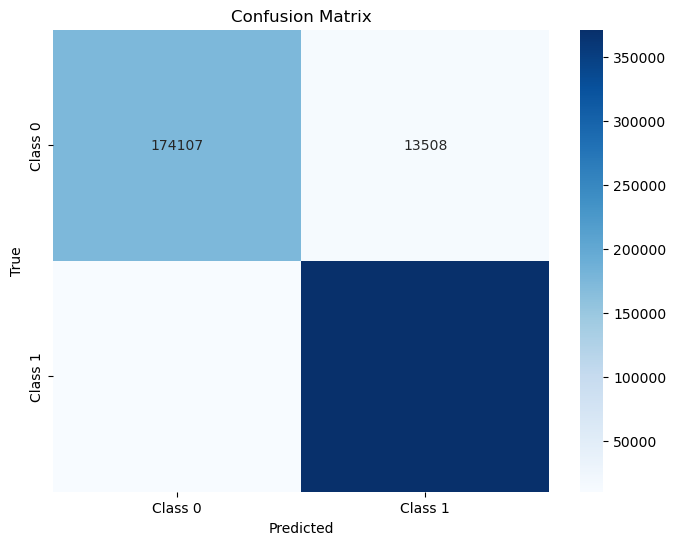


    
    
Partial evaluation: 0.96
Iteración 2
Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 

Columns in multi_series: Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       'series_id_0a96f4993bd7', 'series_id_0cfc06c129cc',
       'series_id_1087d7b0ff2e', 'series_id_10f8bc1f7b07',
       'series_id_18b61dd5aae8', 'series_id_29c75c018220'],
      dtype='object')
Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       's

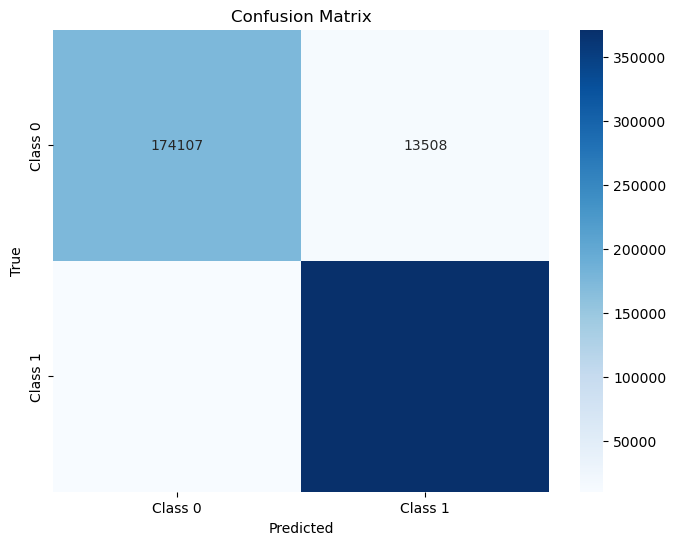


    
    
Partial evaluation: 0.96
Iteración 3
Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 

Columns in multi_series: Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       'series_id_0a96f4993bd7', 'series_id_0cfc06c129cc',
       'series_id_1087d7b0ff2e', 'series_id_10f8bc1f7b07',
       'series_id_18b61dd5aae8', 'series_id_29c75c018220'],
      dtype='object')
Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       's

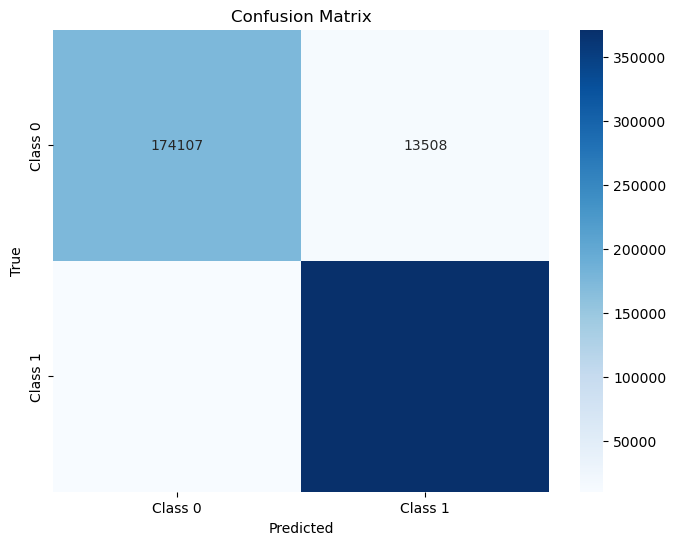


    
    
Partial evaluation: 0.96
Iteración 4
Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 

Columns in multi_series: Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       'series_id_0a96f4993bd7', 'series_id_0cfc06c129cc',
       'series_id_1087d7b0ff2e', 'series_id_10f8bc1f7b07',
       'series_id_18b61dd5aae8', 'series_id_29c75c018220'],
      dtype='object')
Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       's

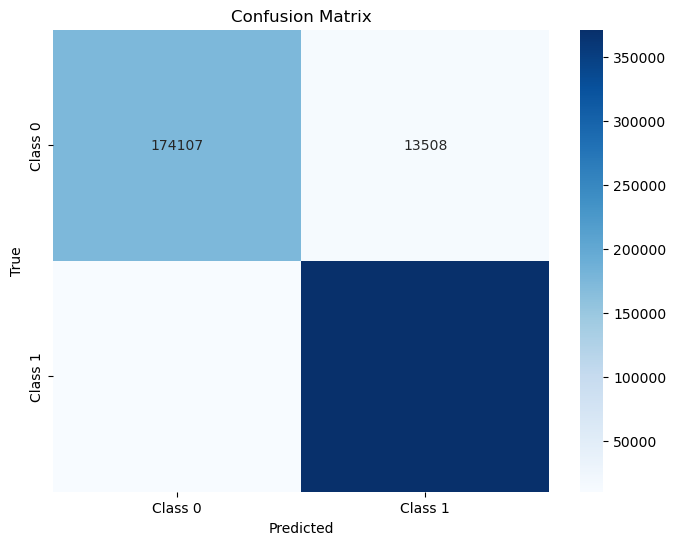


    
    
Partial evaluation: 0.96
Iteración 5
Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 

Columns in multi_series: Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       'series_id_0a96f4993bd7', 'series_id_0cfc06c129cc',
       'series_id_1087d7b0ff2e', 'series_id_10f8bc1f7b07',
       'series_id_18b61dd5aae8', 'series_id_29c75c018220'],
      dtype='object')
Index(['step', 'anglez', 'enmo', 'awake', 'hour', 'dayofweek',
       'anglez_times_enmo', 'anglez_mean', 'anglez_min', 'anglez_max',
       'anglez_std', 'anglez_diff', 'anglez_diff_rolling', 'enmo_mean',
       'enmo_min', 'enmo_max', 'enmo_std', 'enmo_diff', 'enmo_diff_rolling',
       's

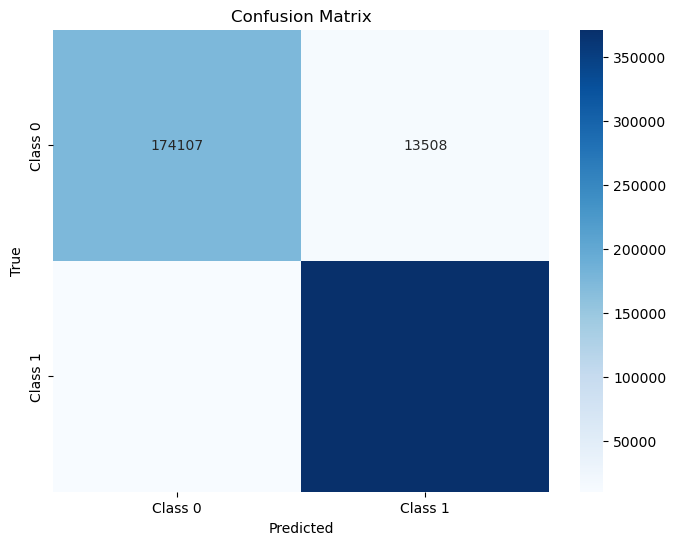


    
    
Partial evaluation: 0.96

Average Results:
Average Accuracy: 0.96
Average Recall: 0.97
Average Specificity: 0.93
Average Average Precision: 1.00
Final Evaluation: 0.96


In [13]:
if __name__ == "__main__":
    main()